In [18]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [19]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script> so much code! click <a href="javascript:code_toggle()">here</a>.''')

In [20]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp
import pandas as pd
import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc
import pickle
import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy

#from matplotlib import reload
import arrow
import gsw
import time

%matplotlib inline

plt.rcParams.update({'font.size': 20,
                     'xtick.labelsize' : 20,
                     'ytick.labelsize' : 20})



In [48]:

import BC_helper_methods as hm
import importlib
importlib.reload(hm)

<module 'BC_helper_methods' from '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/RIVER_PAPER/future_pilot/INITIALIZATION/BC_helper_methods.py'>

In [38]:
# def co2_from_year(scen,tyear):
#     import pandas as pd
#     import numpy as np

#     #get witnessed co2, currently only takes 2-4.5 and 5-8.5

#     df = pd.read_csv('./meinshausen/meinshausen_scenario_conc.csv')
#     data_top = list(df.columns) 
# #     print('available data columns')
# #     print(data_top)

#     year = np.array(df['year'][:])
#     # SSP1_1pt9_NH = np.array(df['SSP1-1.9_NH'][:])
#     # SSP1_2pt6_NH = np.array(df['SSP1-2.6_NH'][:])
#     # SSP2_4pt5_NH = np.array(df['SSP2-4.5'][:])
#     SSP2_4pt5_NH = np.array(df['SSP2-4.5'][:])
#     SSP5_8pt5_NH = np.array(df['SSP5-8.5'][:])

#     q = np.shape(tyear)
#     tco2_ar = np.zeros_like(tyear)
#     tyear_r = np.ravel(tyear)
#     tco2_ar_r = np.ravel(tco2_ar)
#     for i in range(0,len(tco2_ar_r)):
#         # building for 2_4pt5
#         if (scen == '2_4pt5'): 

#             tco2_ar_r[i] = SSP2_4pt5_NH[year == (int(tyear_r[i]))]

#         if scen == '5_8pt5':

#             tco2_ar_r[i] = SSP5_8pt5_NH[year == (int(tyear_r[i]))]
    
#     #tco2_ar = tco2_ar_r.reshape(q[0],q[1])

#     return tco2_ar

In [39]:
print('warlurs')

warlurs


In [40]:
obs_year = [2015]
target_year = [2050]
scen = '2_4pt5'
DIC = 1800
TA = 2190
T = 7
S = 31


def Pacella_TCO2_PI(obs_year,target_year, scen, tsal, ttemp, dic, ta, verbose = False):
    

    watermass_witnessed_co2_obs = int(hm.co2_from_year_pointmeas(scen,obs_year))
    watermass_witnessed_co2_target = 280
    
    if verbose:
        print(f'obs year: {obs_year}')
        print(f'obs year co2: {watermass_witnessed_co2_obs}')
        print(f'target year: {target_year}')
        print(f'target year co2: {watermass_witnessed_co2_target}')
    
    DIC_obs_eq = hm.find_DIC_corresp_to_pco2(tsal, ttemp, watermass_witnessed_co2_obs, ta, 1, 0)
    del_TCO2 = dic - DIC_obs_eq
    
    DIC_target_eq = hm.find_DIC_corresp_to_pco2(tsal, ttemp, watermass_witnessed_co2_target, ta, 1, 0)
    DIC_target_final = DIC_target_eq + del_TCO2
    DIC_intrusion = DIC_target_final-dic
    #DIC_obs_real = hm.find_DIC_corresp_to_pco2(tsal, ttemp, watermass_witnessed_co2_obs, tta, 1, 0)
    if verbose:
        print('')
        #print(del_TCO2)
        print(f'this is what DIC would be at equilibrium (obs): {DIC_obs_eq}')
        print(f'this is what DIC actually is (obs): {dic}')
        print(f'this is the del TCO2: {del_TCO2}')
        print(f'this is what DIC would be at equilibrium (target): {DIC_target_eq}')
        print(f'this is what DIC actually should/would be (target): {DIC_target_eq + del_TCO2}')
        print(f'this is the intrusion: {DIC_intrusion}')
        
    #print(f'this is the intrusion: {DIC_intrusion}')
    return DIC_intrusion

Pacella_TCO2_PI(obs_year,target_year, scen, S, T, DIC, TA, verbose = True)



obs year: [2015]
obs year co2: 401
target year: [2050]
target year co2: 280

this is what DIC would be at equilibrium (obs): 2055.4799999995957
this is what DIC actually is (obs): 1800
this is the del TCO2: -255.47999999959575
this is what DIC would be at equilibrium (target): 2000.939999999611
this is what DIC actually should/would be (target): 1745.4600000000153
this is the intrusion: -54.53999999998473


-54.53999999998473

In [70]:
def point_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):

    ### GET pCO2 (and Omega, etc) GIVEN DIC, TA 
    import sys
    sys.path.append('/data/tjarniko/mocsy')
    import mocsy
    import numpy as np
    import gsw

    tsra = (tsal)
    ttera = (ttemp)
    #convert cons. temperature to potential temperature
    ttera_pot = gsw.pt_from_CT(tsra,ttera)
#     print('insitu vs potential temperature')
#     print(ttera)
#     print(ttera_pot)
    
    ttara = (tta) * 1e-3
    tdra = (tdic) * 1e-3
    tzero = 0
    tpressure = pres_atm
    tdepth = (depth_this)
    tsra_psu = tsra*35/35.16504
    #ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_pot, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tpot', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    pHr = pH
    OmAr = OmegaA
    pco2r = pco2
    
    return pHr, OmAr, pco2r



In [73]:
def calc_surface_intrusion_Pacella_method(arrowdate, obs_year, target_year, scen, verbose = False):
    import numpy as np
    import netCDF4 as nc
    import gsw
    
    test_LO = hm.load_nc(arrowdate)
    
    tdate = arrowdate
    yy = tdate.format('YYYY')
    mm = tdate.format('MM')
    dd = tdate.format('DD')
    ymd = f'y{yy}m{mm}d{dd}'
    #open dataset & retrieve relevant variables, calculate potential density

    #get just the surface intrusion
    zlevels = (test_LO['deptht'][:])
    sal = test_LO['vosaline'][0,0,0,:]
    temp = test_LO['votemper'][0,0,0,:]
    sigma0 = gsw.sigma0(sal,temp)
    DIC = test_LO['DIC'][0,0,0,:]
    TA = test_LO['TA'][0,0,0,:]
    
    intrusion = np.zeros_like(DIC)
    start = time.time()


    #hardcode size of array 
    i = 450
    intrusion = Pacella_TCO2_PI(obs_year, target_year, scen, sal[i], temp[i], DIC[i], TA[i], verbose = False)
#     print('seconds taken at the hard part')
#     print(time.time()-start)
    

    pHr, OmAr, pco2r = point_moxy(sal[i], temp[i], DIC[i], TA[i], 1, 0)
    if verbose:
        print(f'DIC is {DIC[i]}, TA is {TA[i]}')
        print(f'pco2 is {pco2r}')
    
    
    
    return intrusion, pco2r, DIC[i], TA[i], sal[i], temp[i]
#     f = nc.Dataset(f'./JdF_future_DIC/LO_TY_{target_year}_scen_{scen}_{ymd}_DIC_PacellaSurf.nc','w', format='NETCDF4') #'w' stands for write
#     g = f.createGroup('preindustrial_DIC')
#     g.createDimension('xval', 950)
#     g.createDimension('depth', 1)

#     ts = g.createVariable('DIC_intrusion','f4',('depth','xval'))
#     ts[:] = intrusion

#     f.close()

In [74]:
start ='2015-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)
    
intrs = np.zeros(365)
pco2s = np.zeros(365)
DICs = np.zeros(365)
TAs = np.zeros(365)
sals= np.zeros(365)
temps = np.zeros(365)
for i in range(0,365):
    if i%30 == 0:
        print(i)
    intrusion, pco2r, DIC, TA, sal, temp = calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2015, 2050, '2_4pt5', False)
    intrs[i] = intrusion
    pco2s[i] = pco2r
    DICs[i] = DIC
    TAs[i] = TA
    sals[i] = sal
    temps[i] = temp
    
    


0
30
60
90
120
150
180
210
240
270
300
330
360


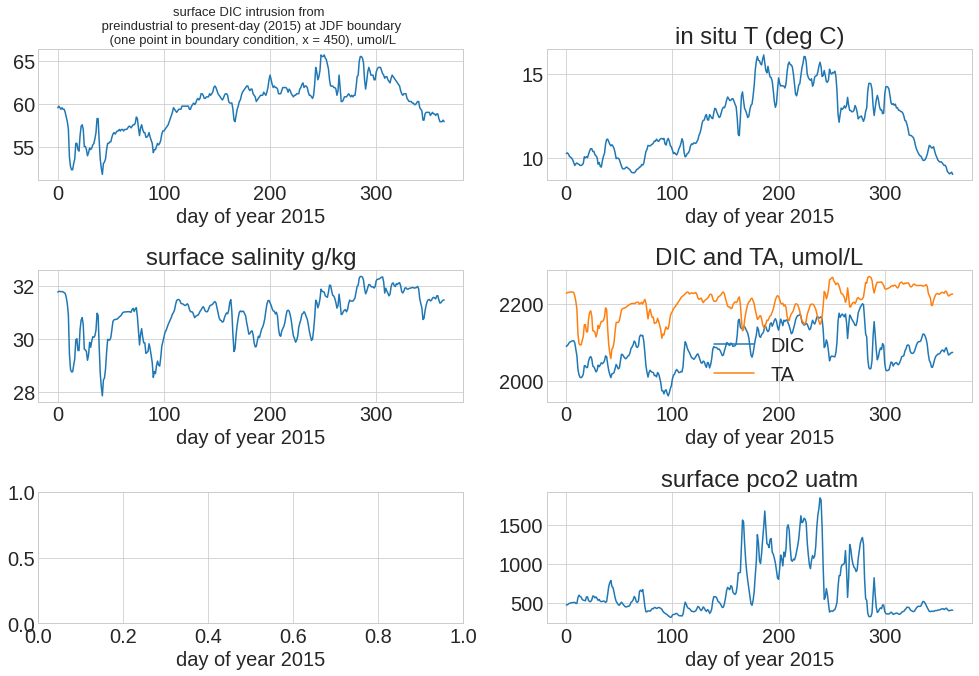

In [87]:
# plt.plot(-intrs)
# plt.ylabel('umol/L')
# plt.title('surface DIC intrusion from \n preindustrial to present-day (2015) at JDF boundary \n (one point in boundary condition, x = 450) ')
# plt.xlabel('day of year')
# np.nanmean(-intrs)


## plotting
fact = 0.7
fig, axs = plt.subplots(3,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
\
axs[0].plot(-intrs), axs[0].set_title('surface DIC intrusion from \n preindustrial to present-day (2015) at JDF boundary \n (one point in boundary condition, x = 450), umol/L', fontsize = 13)
axs[2].plot(sals), axs[2].set_title('surface salinity g/kg')
axs[1].plot(temps), axs[1].set_title('in situ T (deg C)')
axs[3].plot(DICs, label = 'DIC'), axs[3].set_title('DIC and TA, umol/L')
axs[3].plot(TAs, label = 'TA'), axs[3].legend()
axs[5].plot(pco2s), axs[5].set_title('surface pco2 uatm')

for i in range(0,6):
    axs[i].set_xlabel('day of year 2015')
plt.tight_layout()

In [ ]:
from multiprocessing import Process

start ='2017-01-01'
end ='2017-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)
    
    
def func1():
  print('func1: starting')
  for i in range(0,60):
        calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2017, 2050, '2_4pt5')

def func2():
  print('func2: starting')
  for i in range(60,120):
        calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2017, 2050, '2_4pt5')
      
def func3():
  print('func3: starting')
  for i in range(120,180):
        calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2017, 2050, '2_4pt5')
        
def func4():
  print('func4: starting')
  for i in range(180,240):
        calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2017, 2050, '2_4pt5')
        
def func5():
  print('func5: starting')
  for i in range(240,300):
        calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2017, 2050, '2_4pt5')
        
def func6():
  print('func36: starting')
  for i in range(300,366):
        calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2017, 2050, '2_4pt5')
        
if __name__ == '__main__':
  p1 = Process(target=func1)
  p1.start()
  p2 = Process(target=func2)
  p2.start()
  p3 = Process(target=func3)
  p3.start()
  p4 = Process(target=func4)
  p4.start()
  p5 = Process(target=func5)
  p5.start()
  p6 = Process(target=func6)
  p6.start()                
    
  p1.join()
  p2.join()
  p3.join()
  p4.join()
  p5.join()
  p6.join()

In [ ]:
def deltaDIC_method()

In [ ]:
w = nc.Dataset('./JdF_future_DIC/LO_TY_2050_scen_2_4pt5_y2017m01d01_DIC_nosurfnodeep.nc')
print(w['preindustrial_DIC'])

In [ ]:
tcmap = cm.cm.deep
cmap = tcmap
test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m01d01.nc')
zlevels = (test_LO['deptht'][:])

fig = plt.figure(figsize=(11,3.5))

ax = fig.add_subplot(1,5,1)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['sigma0'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('sigma0') 
ax.set_ylabel('depth')
ax.set_xticklabels([])

ax = fig.add_subplot(1,5,2)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['water_age'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('water_age') 
ax.set_ylabel('depth')
ax.set_xticklabels([])


ax = fig.add_subplot(1,5,3)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['AOU_stoich'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('stoichiometric AOU') 
ax.set_ylabel('depth')
ax.set_xticklabels([])

ax = fig.add_subplot(1,5,4)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['final_target_DIC'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('final target DIC') 
ax.set_ylabel('depth')
ax.set_xticklabels([])


ax = fig.add_subplot(1,5,5)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['targetyear_pref_dic'][:,0:95]-\
     w['preindustrial_DIC']['obsyear_pref_dic'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('DIC intrusion yr 2050') 
ax.set_ylabel('depth')
ax.set_xticklabels([])
        
plt.suptitle('y2015m01d01 - basic parameters and extra DIC, year 2050, SSP245 ', fontsize = 15)
plt.tight_layout()

In [ ]:
q = w['preindustrial_DIC']['AOU_stoich'][:,0:95]
print(q)